In [55]:
import PIL

import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torchvision.models as models

from pathlib import Path
from skimage.color import rgb2gray
from skimage.util import invert
from torch import FloatTensor
from torch import nn
from torch.nn import Conv2d, Linear
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

# normalizeStaining comes from https://github.com/schaugf/HEnorm_python
# This uses a H&E normalization strategy described in:
#  M Macenko, M Niethammer, JS Marron, D Borland, JT Woosley, G Xiaojun,
#   C Schmitt, NE Thomas, IEEE ISBI, 2009.
from normalizeStaining import normalizeStaining

# data directory
root = Path("E:\data512_2k")

RGB


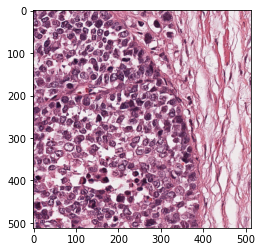

In [2]:
# Test out normalizeStaining
impath = list(root.glob('*/*/*.jpg'))[24]
with PIL.Image.open(impath) as im:
    print(im.mode)
    im = np.asarray(im)
plt.imshow(im);

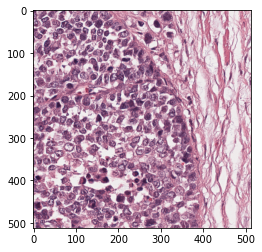

In [3]:
im_norm, h, e = normalizeStaining(im)
plt.imshow(im_norm);

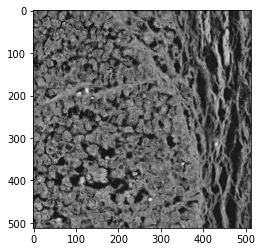

In [4]:
plt.imshow(invert(rgb2gray(e)), cmap='gray');

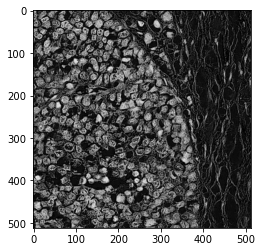

In [5]:
plt.imshow(invert(rgb2gray(h)), cmap='gray');

In [6]:
class ExtractStains:
    '''Normalize H&E staining and assign H&E staining to channels'''
    
    def __call__(self, x):
        '''x is a RGB PIL image, returns a Tensor'''
        outarr = np.zeros((2, *x.size))
        im = np.asarray(x)
        _, h, e = normalizeStaining(im)
        outarr[0, ...] = invert(rgb2gray(h))
        outarr[1, ...] = invert(rgb2gray(e))
        return FloatTensor(outarr)

def extract_stains(pil_im):
    outarr = np.zeros((*pil_im.size, 2))
    im = np.asarray(pil_im)
    _, h, e = normalizeStaining(im)
    outarr[..., 0] = invert(rgb2gray(h))
    outarr[..., 1] = invert(rgb2gray(e))
    return outarr

In [60]:
means = np.array([0.21757597, 0.25600186])
stds = np.array([0.06740291, 0.05294249])

data_transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(192),
        transforms.RandomHorizontalFlip(),
        ExtractStains(),
        transforms.Normalize(mean=means, std=stds)
    ])

data_transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(192),
        ExtractStains(),
        transforms.Normalize(mean=means, std=stds)
    ])

In [61]:
#datasets
data_test = ImageFolder(root / "test", transform=data_transform_test)
data_train = ImageFolder(root / "train", transform=data_transform_train)
data_valid = ImageFolder(root / "valid", transform=data_transform_test)

#dataloaders
dl_test = DataLoader(data_test, batch_size=4, shuffle=True)
dl_train = DataLoader(data_train, batch_size=4, shuffle=True)
dl_valid = DataLoader(data_valid, batch_size=4, shuffle=True)

torch.Size([4, 2, 192, 192])


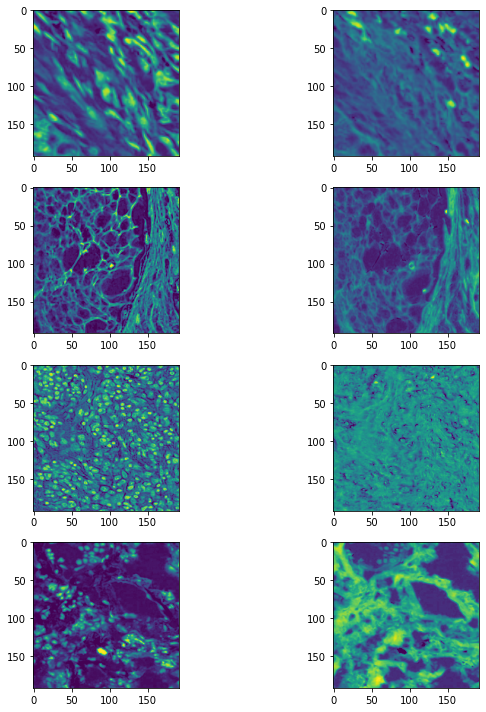

In [65]:
ims, _ = next(iter(dl_train))
print(ims.shape)
fig, axs = plt.subplots(ims.shape[0],2, figsize=(10,10), layout='tight')
for i, ax in enumerate(axs):
    for j, axx in enumerate(ax):
        axx.imshow(ims[i, j, :, :])

In [66]:
model = models.convnext_large()
model.features[0][0] = Conv2d(2, 192, kernel_size=(4, 4), stride=(4, 4))
model.classifier[2] = Linear(in_features=1536, out_features=4, bias=True)

In [67]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

800